In [1]:
import collections
import itertools

import numpy as np
import pandas as pd
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def assign_colors(categorical):

    uniq = list(set(categorical))
    categorical_to_number = pd.factorize(categorical)[0]

    cmap = plt.get_cmap('brg') # https://matplotlib.org/tutorials/colors/colormaps.html
    cnorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cnorm, cmap=cmap)
    color_map = [scalarMap.to_rgba(i) for i in categorical_to_number]

    return color_map


def perform_pca(X, y, perc, visualize=True):
    std_vals = StandardScaler().fit_transform(X)

    pca = PCA(perc)
    principal_comps = pca.fit_transform(std_vals)

    principal_df = pd.DataFrame(data=principal_comps)

    print('Number of principal components explain {}% variance of data is {}'.format(perc*100, len(pca.explained_variance_ratio_)))

    if visualize:
        fig = plt.figure(figsize=(16, 16))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlabel('PC 1', fontsize=12)
        ax.set_ylabel('PC 2', fontsize=12)
        ax.set_title('2 Components PCA', fontsize=15)

        for group in set(y):
            idx = np.where(y == group)[0]
            ax.scatter(principal_df.loc[idx, 0], principal_df.loc[idx, 1], label=group)

        ax.legend()
        ax.grid(True)

        plt.show()

    # print(pca.explained_variance_ratio_)
    # print(principal_df.values)

    # return pca.explained_variance_ratio_, principal_df.values

    return None

def heatmap(X, y, row_linkage, col_linkage):
    g = sns.clustermap(
        X, figsize=(16,16), z_score=0,
        row_linkage=feature_linkage, col_linkage=sample_linkage,
        col_colors=assign_colors(y)
    )

    plt.show()    

def read_libsvm_format(url, classA, classB):
    df = pd.read_csv(url, sep=' ', header=None)
    df = df.dropna(axis=1, how='all') # drop empty columns
    df = df.dropna() #drop all rows that have any NaN values
    labels = df.iloc[:,0].values
    labels[np.where(labels==classA)] = 0
    labels[np.where(labels==classB)] = 1

    df = df.iloc[:,1:].applymap(lambda x: x.split(':')[1])
    df['class'] = labels
    df = df.astype(float)
    df['class'] = df['class'].astype(int)

    return df

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    

def report(clf, model):
    best_result = clf.best_score_
    print('Best classification accuracy of {} models: {}'.format(model, best_result))
    best_parameters = clf.best_params_
    print('Parameters of the best {} model: {}'.format(model, best_parameters))


def classify(X, y, classifier, grid_params, name):
    clf = GridSearchCV(classifier, grid_params, scoring='accuracy',
                       cv=5, verbose=0, n_jobs=-1) # for detailed log verbose=2
    clf.fit(X, y)

    report(clf, name)

In [3]:
#breast = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/breast-cancer_scale' # class labels: 2, 4
#df = read_libsvm_format(diabetes, 2, 4)
#leukemia = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/leu.bz2' # class labels: -1, 1
#df = read_libsvm_format(diabetes, -1, 1)
diabetes = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes_scale' # class labels: -1, 1
df = read_libsvm_format(diabetes, -1, 1)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

Number of principal components explain 90.0% variance of data is 7


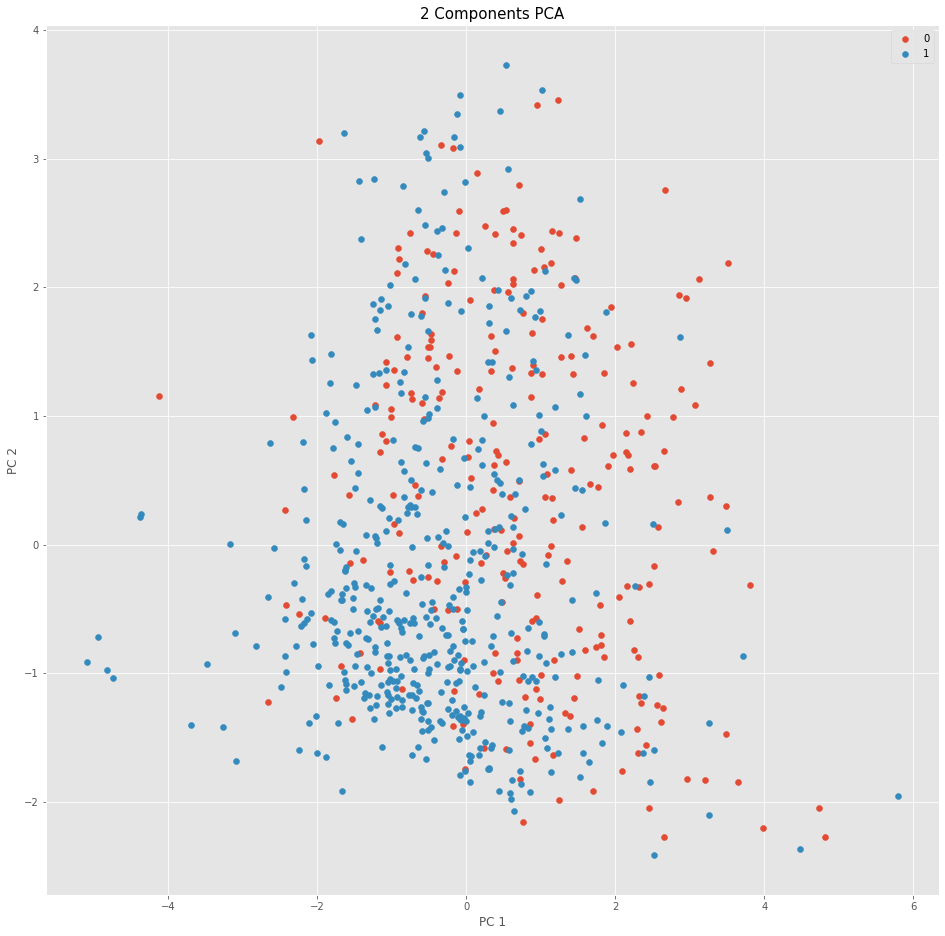

In [4]:
perform_pca(X, y, 0.90)

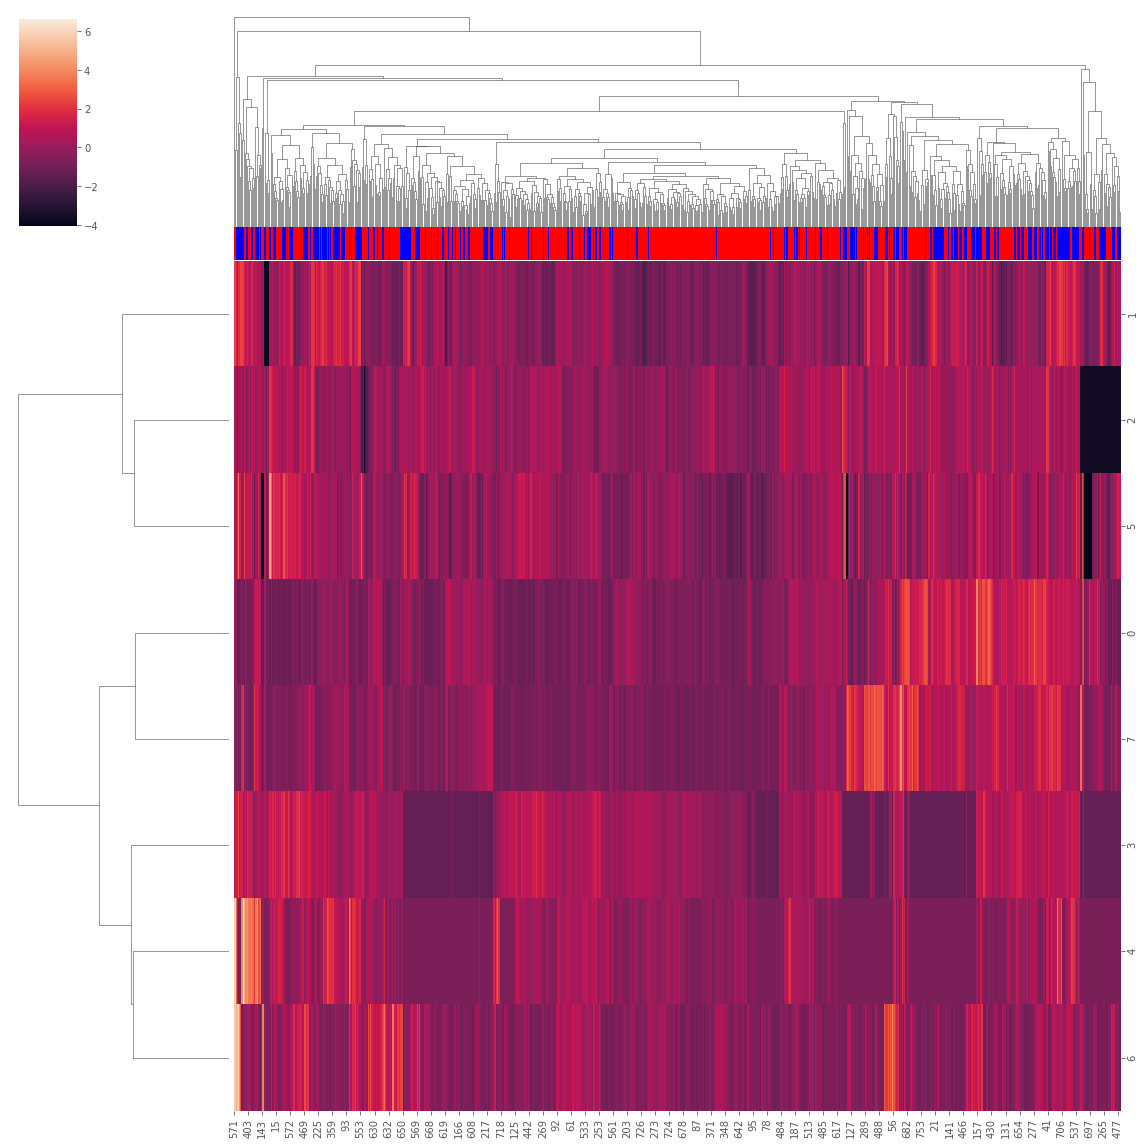

In [5]:
sample_dist = sp.distance.pdist(X, 'euclidean')
feature_dist = sp.distance.pdist(X.T, 'euclidean')

sample_linkage = hc.linkage(sample_dist, method='average')
feature_linkage = hc.linkage(feature_dist, method='average')

heatmap(X.T, y, sample_linkage, feature_linkage)

In [6]:
###SVM
svm_param_grid = [
    {
        'C': [1, 10, 100, 1000],
        'class_weight': [None, 'balanced'], 'kernel': ['linear']
    },
    {
        'C': [1, 10, 100, 1000], 'degree': np.arange(1,11),
        'class_weight': [None, 'balanced'], 'kernel': ['poly']
    },
    {
        'C': [1, 10, 100, 1000],
        'class_weight': [None, 'balanced'],
        'kernel': ['rbf', 'sigmoid']
    },
]

svc = svm.SVC(gamma='scale')
classify(X, y, svc, svm_param_grid, 'SVM')

Best classification accuracy of SVM models: 0.7733792262112235
Parameters of the best SVM model: {'C': 1, 'class_weight': None, 'degree': 2, 'kernel': 'poly'}


In [7]:
###Logistic Regression
lor_param_grid = [
    {
        'C':[1, 10, 100, 1000], 'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    {
        'C':[1, 10, 100, 1000], 'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'class_weight': [None, 'balanced']
    }
]

lor = LogisticRegression()

classify(X, y, lor, lor_param_grid, 'Logistic Regression')

Best classification accuracy of Logistic Regression models: 0.7734053677239455
Parameters of the best Logistic Regression model: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


Accuracy: 0.75

              precision    recall  f1-score   support

           0       0.80      0.52      0.63        31
           1       0.73      0.91      0.81        45

    accuracy                           0.75        76
   macro avg       0.77      0.71      0.72        76
weighted avg       0.76      0.75      0.74        76



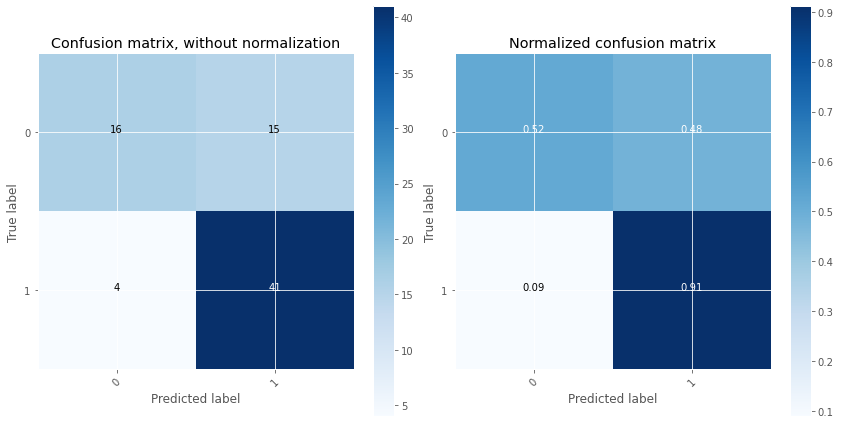

In [8]:
###Best Model Training-testing
clf = svm.SVC(gamma='scale', C=1, class_weight=None, degree=2, kernel='poly')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: {}\n'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred, target_names=[str(i) for i in set(y_test)]))

cnf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(12,6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=set(y_test),
                      title='Confusion matrix, without normalization')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=set(y_test), normalize=True,
                      title='Normalized confusion matrix')

plt.tight_layout()
plt.show()

In [9]:
import collections
import itertools

import numpy as np
import pandas as pd
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Feature Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [10]:
###Helper Function
def assign_colors(categorical):

    uniq = list(set(categorical))
    categorical_to_number = pd.factorize(categorical)[0]

    cmap = plt.get_cmap('brg') # https://matplotlib.org/tutorials/colors/colormaps.html
    cnorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cnorm, cmap=cmap)
    color_map = [scalarMap.to_rgba(i) for i in categorical_to_number]

    return color_map

def heatmap(X, y, row_linkage, col_linkage):
    g = sns.clustermap(
        X, figsize=(16,16), z_score=0,
        row_linkage=feature_linkage, col_linkage=sample_linkage,
        col_colors=assign_colors(y)
    )

    plt.show()  

In [ ]:
df = pd.read_csv('https://cse.unl.edu/~bioinfo/svm-workshop/data/all_aml_with_samples.csv')
df.head()

In [18]:
genes = df.iloc[0,1:]
genes_desc = df.iloc[1,1:]

X = df.iloc[2:, 1:-1].astype(float)
X = X.dropna(axis=1, how='all') # drop empty columns
X = X.dropna() #drop all rows that have any NaN values
X = X.values
print(X.shape)

y = df.iloc[2:, -1].values
print(y)

std_vals = StandardScaler().fit_transform(X)

print(np.mean(std_vals[:,99]))
print(np.std(std_vals[:,99]))

(757, 7)
[0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1
 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0
 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0
 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0
 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1
 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 1 1 1

IndexError: index 99 is out of bounds for axis 1 with size 7

In [19]:
###Build and evaluate initial model with all features
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# description for the parameters is in the above link

clf = svm.SVC(kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(std_vals, y, test_size=0.2, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: {}\n'.format(accuracy_score(y_test, y_pred)))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
cnf_matrix = confusion_matrix(y_test, y_pred)
print()
print(cnf_matrix)

Accuracy: 0.756578947368421

33 27 10 82

[[33 27]
 [10 82]]


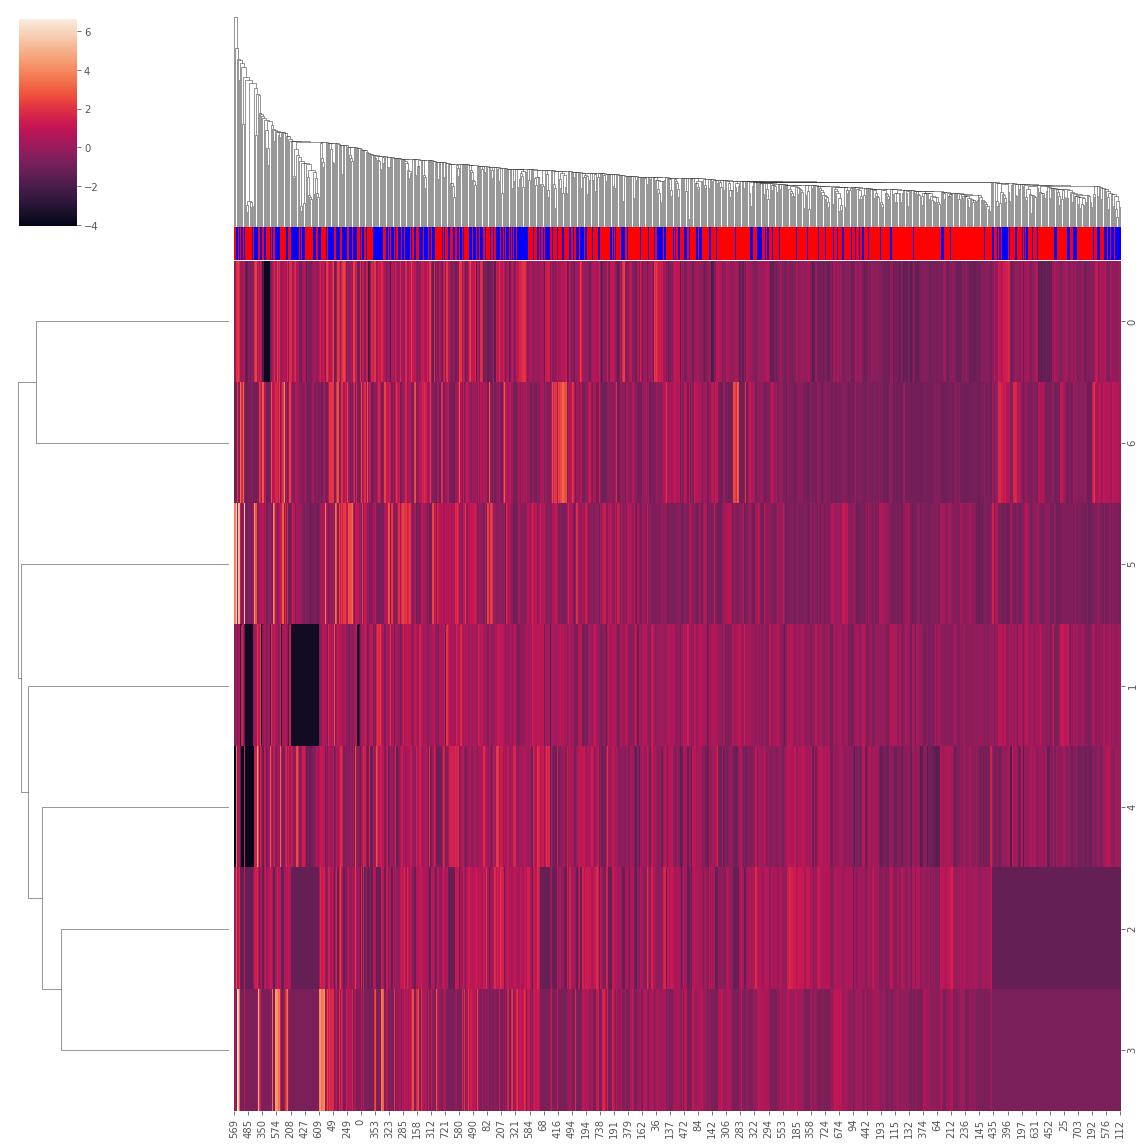

In [20]:
sample_dist = sp.distance.pdist(std_vals, 'euclidean')
feature_dist = sp.distance.pdist(std_vals.T, 'euclidean')

sample_linkage = hc.linkage(sample_dist, method='single')
feature_linkage = hc.linkage(feature_dist, method='average')

heatmap(std_vals.T, y, feature_linkage, sample_linkage)

In [21]:
###Recursive Feature Selection
# Create the RFE object and compute a cross-validated score.
estimator = svm.SVC(kernel='linear')
# The "accuracy" scoring is proportional to the number of correct
# classifications
selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
selector.fit(std_vals, y)
print('Optimal number of features : {}'.format(selector.n_features_))

Optimal number of features : 7


/home/yaolab/mapengchon/.conda/envs/treeclaster/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


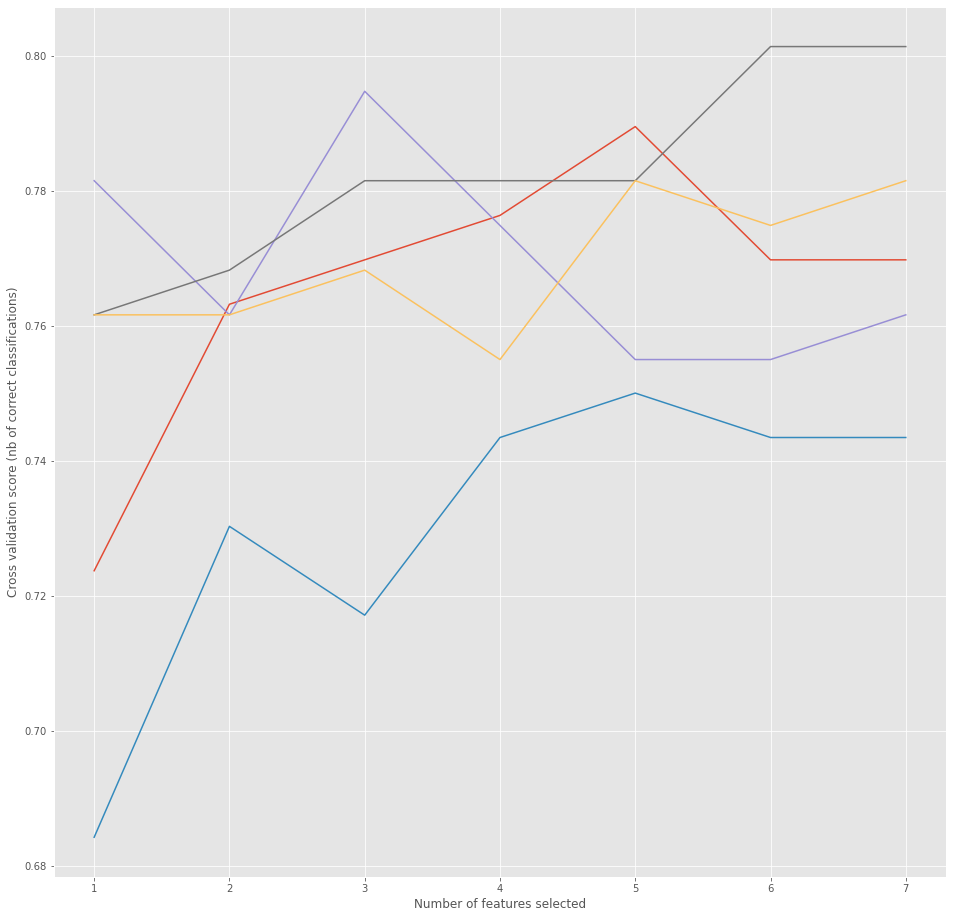

In [22]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(16,16))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [24]:
###Minimal set of most discriminative features
selected_feat_idx = np.where(selector.support_ == True)[0]
affy_probes = genes[selected_feat_idx]
print('Selected Probes')
print('='*80)
print(' '.join(affy_probes))

KeyError: '[0, 1] not in index'

In [25]:
###Best Model evaluation
X_select = std_vals[:, selected_feat_idx]
print(X_select.shape)
clf = svm.SVC(C=1, gamma='scale', kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size=0.2, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: {}\n'.format(accuracy_score(y_test, y_pred)))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
cnf_matrix = confusion_matrix(y_test, y_pred)
print()
print(cnf_matrix)

(757, 7)
Accuracy: 0.756578947368421

33 27 10 82

[[33 27]
 [10 82]]


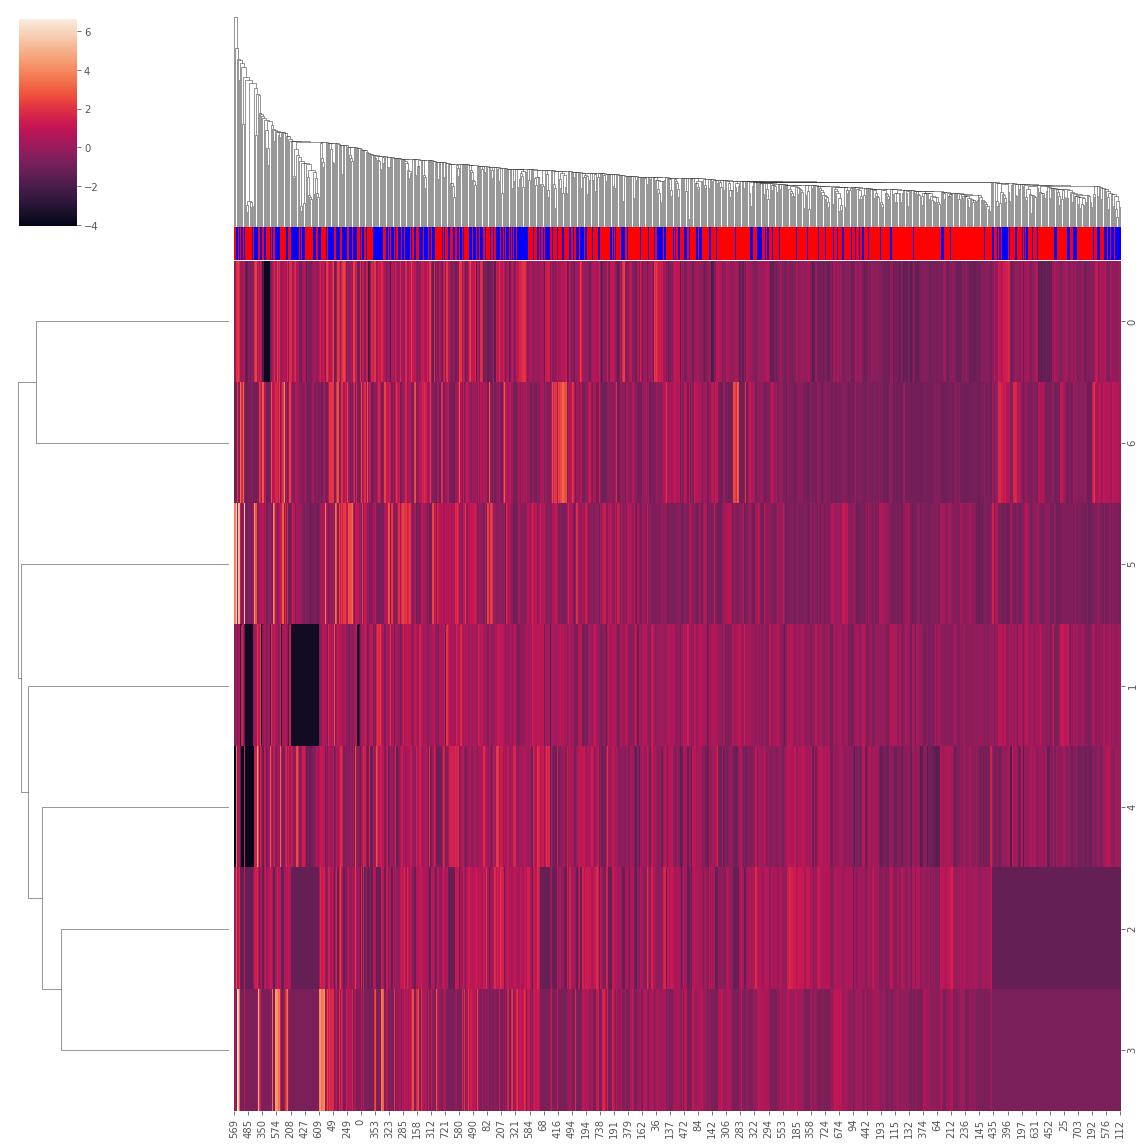

In [26]:
sample_dist = sp.distance.pdist(X_select, 'euclidean')
feature_dist = sp.distance.pdist(X_select.T, 'euclidean')

sample_linkage = hc.linkage(sample_dist, method='single')
feature_linkage = hc.linkage(feature_dist, method='average')

heatmap(X_select.T, y, feature_linkage, sample_linkage)